In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting
import cmocean


/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read in datasets

In [3]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


month_ds_dict = {} 

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'../output/{month}_normal_ds')

# Define constants

In [4]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
times = month_ds_dict[month].time.values

color_map = [
    [6.72862e-01, 1.39087e-01, 2.69400e-03],
    [5.08815e-01, 0.00000e+00, 0.00000e+00],
    [2.99417e-01, 3.66000e-04, 5.48000e-04],
    [0.00000e+00, 0.00000e+00, 6.00000e-06],
    [0.00000e+00, 1.20401e-01, 3.02675e-01],
    [0.00000e+00, 2.16583e-01, 5.24574e-01],
    [1.28047e-01, 4.92588e-01, 7.20288e-01],
    [1.88955e-01, 6.41309e-01, 7.92092e-01],
    [6.08240e-01, 8.92164e-01, 9.35547e-01],
    [9.04481e-01, 6.90489e-01, 0.00000e+00],
    [8.54070e-01, 5.10864e-01, 0.00000e+00],
    [7.77093e-01, 3.30180e-01, 8.82000e-04]
] #modified from Paraview's erdc_iceFire

# Calculate the Energy Budget

Here we calculate an energy budget to ensure that it is closing and that we are not losing any energy from our model

In [5]:
time = times[-2]
co2 = CO2_conc1
timestep = 300
save_freq = 288

In [6]:
energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[months, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

In [7]:
for idx_month, month in enumerate(months):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        tmp_ds = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)
        #atmospheric mass
        energy_budget_df.loc[month, model]['ATM_mass'] = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        
        #TOA Frad
        energy_budget_df.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        energy_budget_df.loc[month, model]['SFC_rad'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        energy_budget_df.loc[month, model]['SFC_turb'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        
        #Atmospheric Advection
        energy_budget_df.loc[month, model]['ATM_adv'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).values.sum()
        
        #Atmospheric Heating
        energy_budget_df.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time+save_freq*timestep))['T'].values - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time))['T'].values)[:-1]/(save_freq*timestep) * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        energy_budget_df.loc[month, model]['energy_budget'] = (energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               energy_budget_df.loc[month, model]['SFC_rad'] +  
                                                               energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               energy_budget_df.loc[month, model]['ATM_heat'])

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


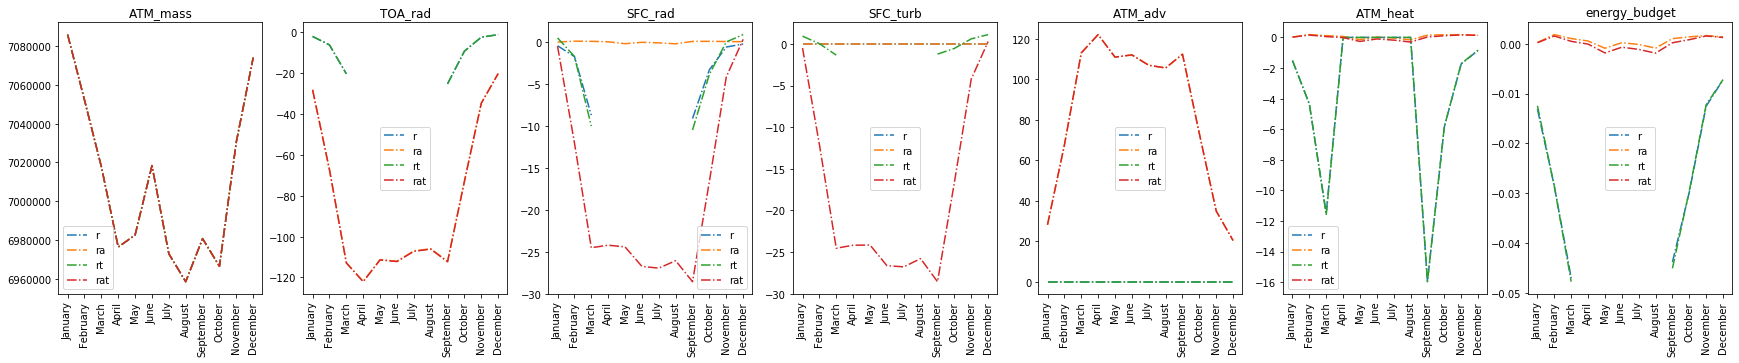

In [8]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

# Standard Atmosphere vs Antarctic

In [9]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


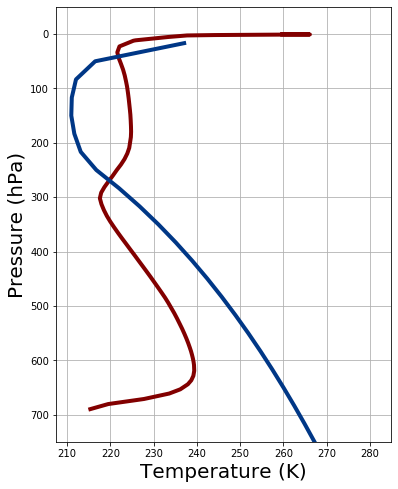

In [11]:
fig, ax = plt.subplots(figsize = [6,8])
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(month_ds_dict[month]['T'].sel(model = 'rat', co2_lev = .00038, time = 0))
    y = month_ds_dict[month]['lev_full']
    plt.plot(x, y, c = color_map[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= color_map[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
#plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')

# Temperature Structure (first timestep and final)

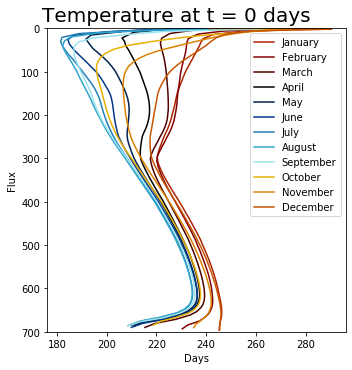

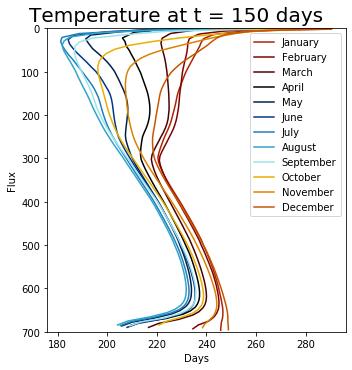

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
color = iter(color_map)

for month in months:
    c = next(color)
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = times[0])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1)['lev_full']
    ax.plot(x, y, label = month, color = c)
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    ax.set_ylim(700,0)
    plt.title('')
    plt.tight_layout()
plt.legend()
plt.suptitle('Temperature at t = 0 days',fontsize = 20, y = 1.02);

fig, ax = plt.subplots(figsize=(5,5))
color = iter(color_map)

for month in months:
    c = next(color)
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = times[-1])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1)['lev_full']
    ax.plot(x, y, label = month, color = c)
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_ylim(700,0)
    plt.title('')
    plt.tight_layout()
plt.legend()
plt.suptitle('Temperature at t = 150 days',fontsize = 20, y = 1.02);

# ASR and OLR

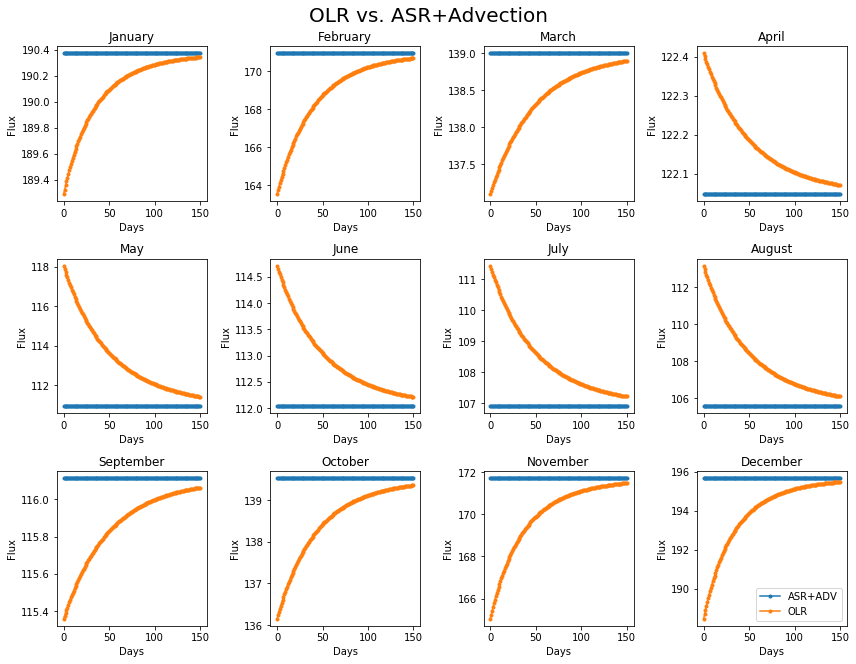

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
axes_list = [item for sublist in axes for item in sublist] 
for month in months:
    ax = axes_list.pop(0)
    y1 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1)['SW_flux_net_clr'][0]+energy_budget_df.loc[month,'rat']['ATM_adv']
    y2 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1)['LW_flux_net_clr'][0]
    x =  month_ds_dict[month].time/ climlab.constants.seconds_per_day
    ax.plot(x, y1, marker = '.', label = 'ASR+ADV')
    ax.plot(x, y2, marker = '.', label = 'OLR')
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    plt.tight_layout()
plt.legend()
plt.suptitle('OLR vs. ASR+Advection',fontsize = 20, y = 1.02);

# Greenhouse Effect

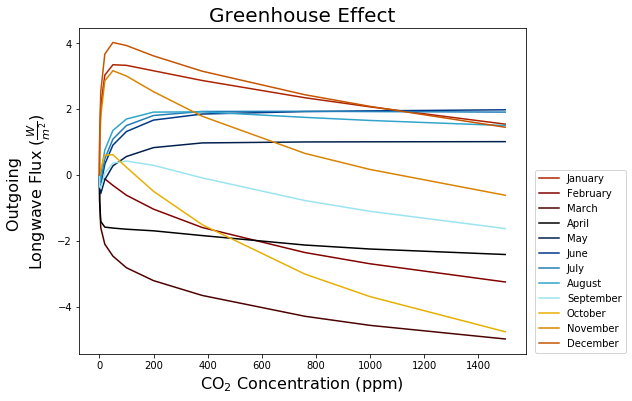

In [14]:
fig, ax = plt.subplots(figsize = (8,6))
color = iter(color_map)

for month in months:
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    plt.plot(x, y,
            label = month, 
             color = next(color))
plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
plt.ylabel('Outgoing \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)
plt.title('Greenhouse Effect', fontsize = 20)
plt.legend(bbox_to_anchor = [1.01, 0.58]);
#plt.savefig('../figures/GHE.png', dpi = 150, bbox_inches = 'tight')

# Scatter plots of bandwidth and Surface CO2 Effect

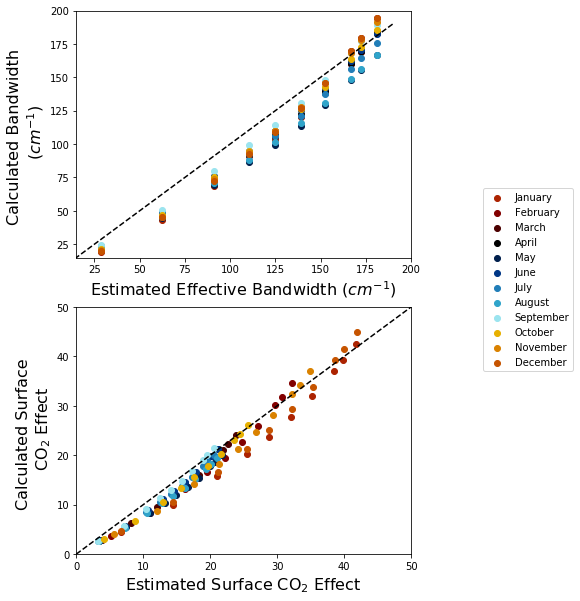

In [15]:
color = iter(color_map)
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (6,10))
for month in months:
    c = next(color)
    
    #bandwidth scatter plot
    x = month_ds_dict[month]['eff_bandwidth_est']
    y = month_ds_dict[month]['eff_bandwidth'][1:]

    ax1.scatter(x, y,
            label = month,
        color = c)
    
    #SFC CO2 effect scatter plot
    x = month_ds_dict[month]['eff_bandwidth_est'].values*month_ds_dict[month]['planck_function'][1:].values
    y = month_ds_dict[month]['sfc_co2_effect'][1:]

    ax2.scatter(x, y,
            label = month,
        color = c)
    
ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.plot(np.arange(0,60,10),np.arange(0,60,10), color = 'k', linestyle = '--')
ax2.set_xlabel('Estimated Surface CO$_2$ Effect', fontsize = 16)
ax2.set_ylabel('Calculated Surface \n CO$_2$ Effect', fontsize = 16)
ax2.legend(bbox_to_anchor = [1.5, 1.5]);

ax1.set_xlim(15,200)
ax1.set_ylim(15,200)
ax1.plot(np.arange(0,200,10),np.arange(0,200,10), color = 'k', linestyle = '--')
ax1.set_xlabel('Estimated Effective Bandwidth ($cm^{-1}$)', fontsize = 16)
ax1.set_ylabel('Calculated Bandwidth \n ($cm^{-1}$)', fontsize = 16)
#plt.tight_layout()
plt.savefig('../figures/sfc_bandwidth_co2_scatter.png', dpi = 150, bbox_inches = 'tight')

# Scatterplot of the Surface Temperature Change

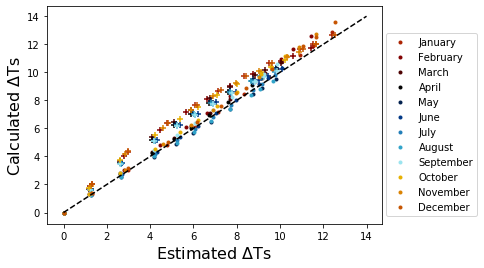

In [16]:
color = iter(color_map)
for month in months:
    x = month_ds_dict[month]['sfc_co2_effect']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    y = month_ds_dict[month]['sfc_co2_estimate']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    z = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
     month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
    c = next(color)
    plt.scatter(z, x,
            label = month,
        color = c, marker = '.')
    plt.scatter(z, y,
        color = c, marker = '+')
plt.plot(np.arange(0,15,1),np.arange(0,15,1), color = 'k', linestyle = '--')
plt.xlabel(r'Estimated $\Delta$Ts', fontsize = 16)
plt.ylabel(r'Calculated $\Delta$Ts', fontsize = 16)
plt.legend(bbox_to_anchor = [1.3, 0.9]);


# Calculate if the dGHE/dCO2 is positive or negative

negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect


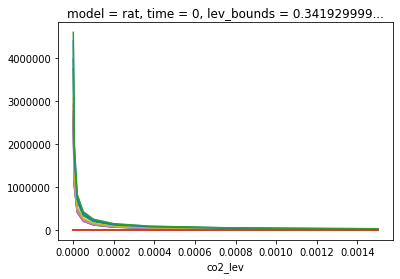

In [17]:
for month in months:
    (month_ds_dict[month]['sfc_co2_effect']/month_ds_dict[month].co2_lev).plot()
    #print a warning if any are less than 0
    if ((month_ds_dict[month]['sfc_co2_effect']/month_ds_dict[month].co2_lev) < 0).any()<0:
        print('negative value in SFC CO2 Effect')
    ((month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])/(month_ds_dict[month].co2_lev*1e6)).plot()
    #print a warning if any are less than 0
    if (((month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])/(month_ds_dict[month].co2_lev*1e6)) < 0).any():
        print('negative value in TOA CO2 Effect')